In [1]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

# Lista 12 cz. 1. (3 pkt.)

## Zadanie 1 (3 pkt.)

Przeprowadź kwantowy atak na szyfr Evena-Mansoura. W tym szyfrze do wiadomości dodajemy za pomocą XORa klucz $k_1$, następnie stosujemy SBox $P$, który zamienia wejściowy ciąg bitów na podany w tabeli (jest to tylko przykładowy, prosty SBox):
$$\begin{array}{|c|c|}
\hline
x&P(x)\\
\hline
000&010\\
001&110\\
010&100\\
011&101\\
100&000\\
101&111\\
110&001\\
111&011\\
\hline
\end{array}
$$
a następnie dodajemy za pomocą XORa $k_2$.

<img src="Even_Mansour.png" width="500"/>

Załóżmy, że znamy pary wiadomość-szyfrogram podane w tabeli:
$$\begin{array}{|c|c|}
\hline
M&E(M)\\
\hline
000&011\\
001&010\\
010&000\\
011&100\\
100&101\\
101&111\\
110&001\\
111&110\\
\hline
\end{array}
$$
Znajdź klucze $k_1$ oraz $k_2$ za pomocą kwantowego algorytmu Simona.

W tym celu definujemy funkcję:
$$f(x)=E(x)\oplus P(x)$$

W algorytmie Simona potrzebujemy dwa razy tyle kubitów ile bitów ma szyfr, czyli w tym przypadku 6:

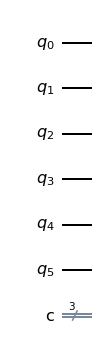

In [2]:
qc = QuantumCircuit(6,3)

qc.draw(output='mpl')

następnie na trzy pierwsze kubity aplikujemy bramki Hadamarda tworząc superpozycję wszytskich możliwych ciągów 3-bitowych:

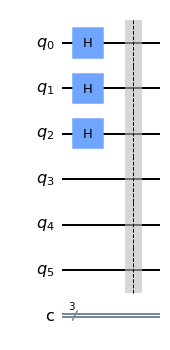

In [3]:
qc.h(range(3))
qc.barrier()
qc.draw(output='mpl')

Teraz musimy zaimplementować obwód kwantowy $U_f$, który stan:
$$|x\rangle|0\rangle$$
przekształci w stan:
$$|x\rangle|f(x)\rangle=U_f|x\rangle|0\rangle$$
Skonstruuj ten obwód. Najpierw wyznacz wartości funkcji $f$ dla wszystkich $x$ (ciągów 3-bitowych) a następnie wydedukuj jak skonstruować odpowiedni obwód $U_f$.

Wskazówka: do skonstruowania tego obwodu wystarczą jedynie bramki **CNOT** oraz jedna bramka **X**.

Uwaga: Na poniższym obwodzie zamiast bramki $U_f$ umieść układ bramek **CNOT**, które będą implementowały działanie operatora $U_f$.

$$\begin{array}{|c|c|}
\hline
x&f(x)\\
\hline
000&001\\
001&100\\
010&100\\
011&001\\
100&101\\
101&000\\
110&000\\
111&101\\
\hline
\end{array}
$$

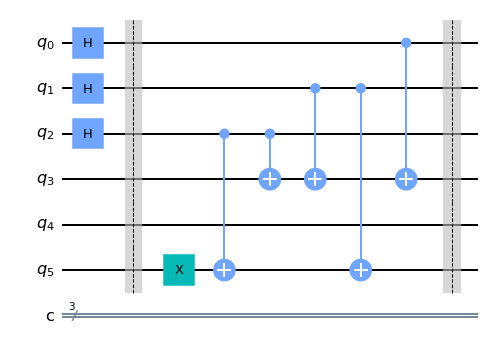

In [4]:
qc.x(5)
qc.cx(2,5)
qc.cx(2,3)
qc.cx(1,3)
qc.cx(1,5)
qc.cx(0,3)

qc.barrier()
qc.draw(output='mpl')


następnie na trzy pierwsze kubity ponownie aplikujemy bramki Hadamarda:

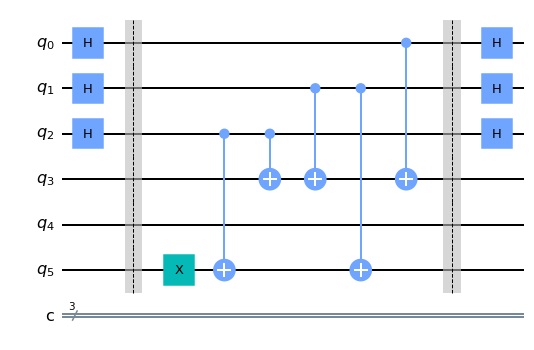

In [5]:
qc.h(range(3))
qc.draw(output='mpl')


i dokonujemy na nich pomiarów:

{'000': 265, '110': 267, '001': 263, '111': 229}


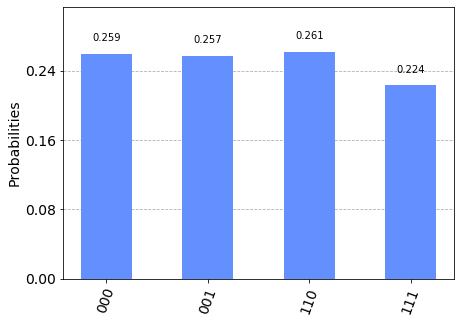

In [6]:
qc.measure(range(3), range(3))
qc.draw(output='mpl')

backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
print(counts)
plot_histogram(counts)

Oznaczmy za pomocą $z_i$ kolejne wyniki pomiarów. Tzn. uruchamiamy obwód z **shots=1** i kolejno uzyskiwane ciągi trzech bitów dają kolejne $z_i$. Szukany przez nas klucz $k_1$ spełnia układ równań:
$$k_1\cdot z_i=0\quad\forall i$$
Gdzie operacja $\cdot$ to iloczyn skalarny ciągów bitów potraktowanych jako wektory, z XORem zamiast dodawania, czyli $a_0a_1a_2\cdot b_0b_1b_2=a_0b_0\oplus a_1b_1\oplus a_2b_2$.

Znajdź wszytskie $z_i$ a następnie znajdź $k_1$.

Teraz, poza znajomością SBoxa $P$ i par wiadomość-szyfrogram, znamy $k_1$. Zastanów się, jak mając te informacje znaleźć $k_2$ i znajdź.

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1).result().get_counts()
plot_histogram(counts)
print(list(counts.keys())[0])

111


In [8]:
def xor(x,y):
    if(x!=y):
        result = 1
    else:
        result = 0
            
    return result

In [9]:
z_i = ['000','100', '011', '111']

def find_k(z_i):
    result = ''
    for i in range(1, 8):
        k = bin(i)[2:].zfill(3)
        count = 0
        for z in z_i:
            is0 = xor(xor(int(k[0])*int(z[0]), int(k[1])*int(z[1])), int(k[2])*int(z[2]))
            if is0==0:
                count += 1
        
        if(count == 4):
            result = k
            break;
        
    return result

print(find_k(z_i))

011


In [10]:
def xor_str(bin_str1,bin_str2):
    result = ''
    for (x,y) in zip(bin_str1, bin_str2):
        if(x!=y):
            result += '1'
        else:
            result += '0'
            
    return result

In [11]:
sBox = {'000': '010', '001': '110', '010': '100', '011': '101', '100': '000', '101': '111', '110': '001', '111': '011'}
M_C = {'000': '011', '001': '010', '010': '000', '011': '100', '100': '101', '101': '111', '110': '001', '111': '110'}
k_1 = '011'
k_2 = []

for i in range(8):
    x = bin(i)[2:].zfill(3)
    x_k = xor_str(x, k_1)
    x_k_p = sBox[x_k]
    
    for j in range(1,8):
        k = bin(j)[2:].zfill(3)
        res = xor_str(x_k_p, k)
        if res == M_C[x]: 
            k_2.append(k)
            
print(k_2)

['110', '110', '110', '110', '110', '110', '110', '110']


$k_1$ = 011
$k_2$ = 110